In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 20 06:42:17 2021

@author: John
"""

# importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline
# %matplotlib notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# Feature Selection with Univariate Statistical Tests
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

import csv
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# suppressing warnings ## NOT RECOMMENDED
import warnings
warnings.filterwarnings("ignore") 

In [3]:
# read dataset
df = pd.read_csv ('recs2015_public_v4.csv')

In [4]:
print (df.head())

   DOEID  REGIONC  DIVISION METROMICRO UATYP10  TYPEHUQ  ZTYPEHUQ  CELLAR  \
0  10001        4        10      METRO       U        2         0       0   
1  10002        3         7       NONE       R        2         0       0   
2  10003        3         6      METRO       U        2         0       1   
3  10004        2         4      MICRO       C        2         0       1   
4  10005        1         2      METRO       U        2         0       1   

   ZCELLAR  BASEFIN    ...      ZELAMOUNT  NGXBTU  PERIODNG  ZNGAMOUNT  \
0        0       -2    ...              0  103.32         1          0   
1        0       -2    ...              1     NaN        -2         -2   
2        0        1    ...              0  100.14         1          0   
3        0        1    ...              0     NaN        -2         -2   
4        0        0    ...              0  102.83         1          0   

   FOXBTU  PERIODFO  ZFOAMOUNT  LPXBTU  PERIODLP  ZLPAMOUNT  
0  137.45        -2         -2

In [5]:
print(df.shape)

(5686, 759)


In [6]:
# print(df.describe())

In [7]:
# manual feature selection

drop_list = []
with open('features_to_drop.csv', 'r', encoding="utf-8-sig", newline='') as file:
#     reader = csv.reader(file)
#     drop_list = list(reader)    
    for row in csv.reader(file):
        drop_list.append(row[0])
# print (drop_list)

In [8]:
df.drop(columns = drop_list, inplace = True)

In [9]:
print(df.head())

   REGIONC  DIVISION METROMICRO UATYP10  TYPEHUQ  CELLAR  BASEFIN  ATTIC  \
0        4        10      METRO       U        2       0       -2      0   
1        3         7       NONE       R        2       0       -2      0   
2        3         6      METRO       U        2       1        1      0   
3        2         4      MICRO       C        2       1        1      0   
4        1         2      METRO       U        2       1        0      1   

   ATTICFIN  STORIES    ...     PELLETAMT  PELLETBTU  ELXBTU  PERIODEL  \
0        -2       20    ...          -2.0        0.0   3.412         1   
1        -2       10    ...          -2.0        0.0   3.412         5   
2        -2       10    ...          -2.0        0.0   3.412         1   
3        -2       10    ...          -2.0        0.0   3.412         1   
4         0       20    ...          -2.0        0.0   3.412         1   

   NGXBTU  PERIODNG  FOXBTU  PERIODFO  LPXBTU  PERIODLP  
0  103.32         1  137.45        -2   

In [10]:
print(df.shape)

(5686, 389)


In [11]:
# manual target selection

target_list = []
with open('targets.csv', 'r', encoding="utf-8-sig", newline='') as file:
#     reader = csv.reader(file)
#     drop_list = list(reader)    
    for row in csv.reader(file):
        target_list.append(row[0])
print (target_list)

['EQUIPMUSE', 'TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'USEWWAC', 'TEMPHOMEAC', 'TEMPGONEAC', 'TEMPNITEAC', 'HHAGE', 'EMPLOYHH', 'EDUCATION', 'NHSLDMEM', 'NUMADULT', 'NUMCHILD', 'ATHOME', 'MONEYPY']


In [12]:
# replace categorial data 
LE = LabelEncoder()
df['METROMICRO'] = LE.fit_transform(df['METROMICRO'])
df['UATYP10'] = LE.fit_transform(df['UATYP10'])
df['CLIMATE_REGION_PUB'] = LE.fit_transform(df['CLIMATE_REGION_PUB'])
df['IECC_CLIMATE_PUB'] = LE.fit_transform(df['IECC_CLIMATE_PUB'])

In [13]:
# removing INF and NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(99999, inplace=True)

In [14]:
def getAgeGroup(age):
    if age < 13:
        return 1
    elif age < 31:
        return 2
    elif age < 51:
        return 3
    elif age < 71:
        return 4
    return 5

In [15]:
# manual classification of age group HHAGE
for i, row in df.iterrows():
    age = row['HHAGE']
    age_group = getAgeGroup(age)
    df.at[i, 'HHAGE'] = age_group

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023633813CC0>]],
      dtype=object)

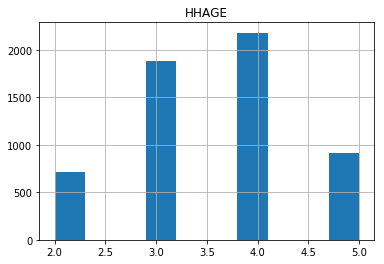

In [16]:
df.hist(column='HHAGE')

In [17]:
def show_correlation(target_col):
    # create traing and test sets
    X = df.drop(target_col, axis='columns')   #Feature Matrix
    y = df[target_col]          #Target Variable
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

    # select feature subset
    feature_selector = SelectKBest(score_func=f_classif, k=10) # select 20 features
    X_train_selected = feature_selector.fit_transform(X_train, Y_train)
    fit = feature_selector.fit(X_train, Y_train) # extra

    # show selected features

    mask = feature_selector.get_support()
    column_names = X_train.columns[mask]
    print("Selected Features for " + target_col)
    print(column_names)

    # Get the indices sorted by most important to least important
#     indices = np.argsort(fit.scores_)[::-1]

    # To get your top 10 feature names
    # feature_count = 10
    # features = []
    # for i in range(feature_count):
    #     features.append(df.columns[indices[i]])

    # plot feature importance
    # plt.figure()
    # plt.bar(features, fit.scores_[indices[range(feature_count)]], color='g', align='center')
    # plt.xticks(rotation=45)
    # plt.title("Feature Subset for " + target_col)
    # plt.show()

    # plot correlation matrix 
    cor = pd.DataFrame(X_train_selected, columns = column_names).corr(method='pearson')
    sns.heatmap(cor, annot=True)
    plt.show()

Selected Features for EQUIPMUSE
Index(['HEATHOME', 'DNTHEAT', 'EQUIPM', 'FUELHEAT', 'THERMAIN', 'PROTHERM',
       'TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'EQUIPAUX'],
      dtype='object')


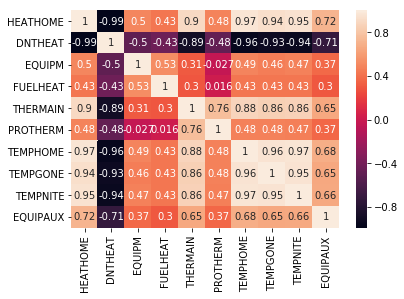




Selected Features for TEMPHOME
Index(['HEATHOME', 'DNTHEAT', 'EQUIPM', 'FUELHEAT', 'THERMAIN', 'PROTHERM',
       'EQUIPMUSE', 'TEMPGONE', 'TEMPNITE', 'EQUIPAUX'],
      dtype='object')


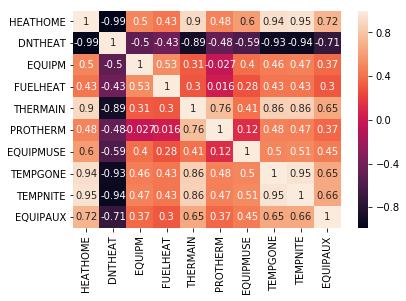




Selected Features for TEMPGONE
Index(['HEATHOME', 'DNTHEAT', 'EQUIPM', 'FUELHEAT', 'THERMAIN', 'PROTHERM',
       'EQUIPMUSE', 'TEMPHOME', 'TEMPNITE', 'EQUIPAUX'],
      dtype='object')


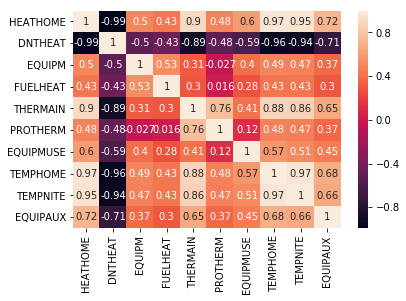




Selected Features for TEMPNITE
Index(['HEATHOME', 'DNTHEAT', 'EQUIPM', 'FUELHEAT', 'THERMAIN', 'PROTHERM',
       'EQUIPMUSE', 'TEMPHOME', 'TEMPGONE', 'EQUIPAUX'],
      dtype='object')


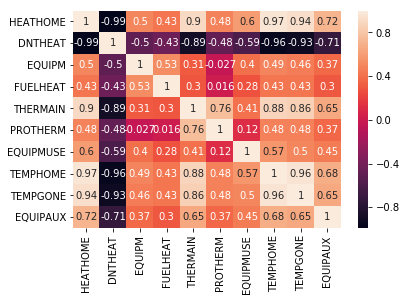




Selected Features for USEWWAC
Index(['DISHWASH', 'COOLTYPE', 'CENACHP', 'AGECENAC', 'THERMAINAC',
       'PROTHERMAC', 'USECENAC', 'NUMBERAC', 'WWACAGE', 'TOTCSQFT'],
      dtype='object')


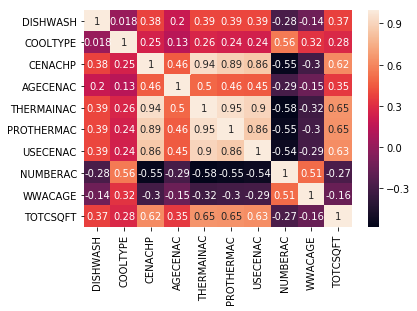




Selected Features for TEMPHOMEAC
Index(['AIRCOND', 'COOLTYPE', 'CENACHP', 'THERMAINAC', 'PROTHERMAC',
       'USECENAC', 'TEMPGONEAC', 'TEMPNITEAC', 'ELCOOL', 'TOTCSQFT'],
      dtype='object')


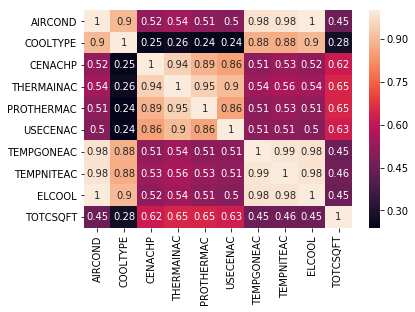




Selected Features for TEMPGONEAC
Index(['AIRCOND', 'COOLTYPE', 'CENACHP', 'THERMAINAC', 'PROTHERMAC',
       'USECENAC', 'TEMPHOMEAC', 'TEMPNITEAC', 'ELCOOL', 'TOTCSQFT'],
      dtype='object')


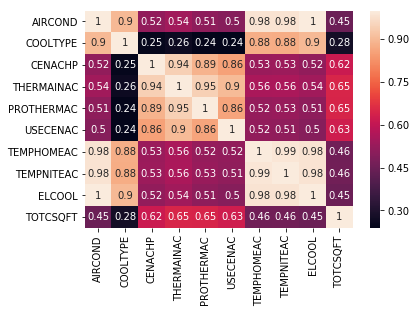




Selected Features for TEMPNITEAC
Index(['AIRCOND', 'COOLTYPE', 'CENACHP', 'THERMAINAC', 'PROTHERMAC',
       'USECENAC', 'TEMPHOMEAC', 'TEMPGONEAC', 'ELCOOL', 'TOTCSQFT'],
      dtype='object')


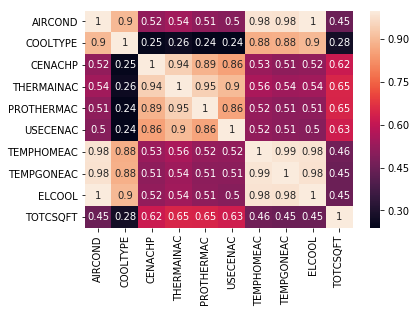




Selected Features for HHAGE
Index(['KOWNRENT', 'OCCUPYYRANGE', 'SWIMPOOL', 'SOLAR', 'PLAYSTA', 'LGTOUTNUM',
       'EMPLOYHH', 'NHSLDMEM', 'NUMCHILD', 'TOTALBTUWTH'],
      dtype='object')


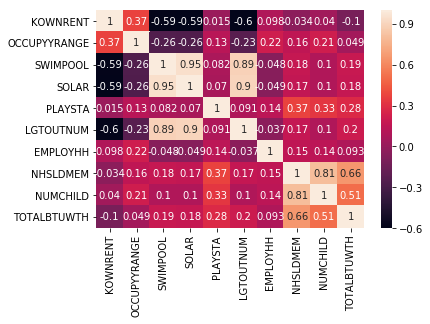




Selected Features for EMPLOYHH
Index(['OCCUPYYRANGE', 'TVONWD1', 'PLAYSTA', 'NUMLAPTOP', 'INTERNET',
       'INWIRELESS', 'HHAGE', 'EDUCATION', 'ATHOME', 'MONEYPY'],
      dtype='object')


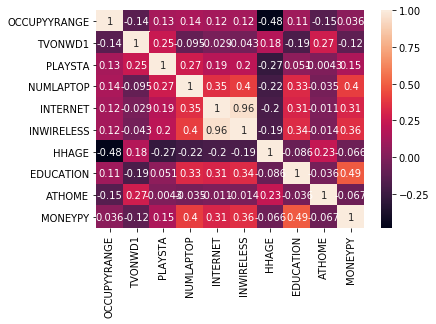




Selected Features for EDUCATION
Index(['NCOMBATH', 'DISHWASH', 'DWASHUSE', 'DWCYCLE', 'NUMLAPTOP', 'ELPERIPH',
       'INTERNET', 'INWIRELESS', 'LGTINNUM', 'MONEYPY'],
      dtype='object')


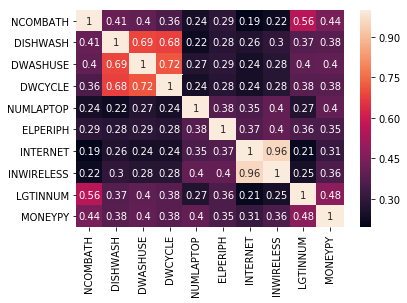




Selected Features for NHSLDMEM
Index(['BEDROOMS', 'WASHLOAD', 'DRYRUSE', 'PLAYSTA', 'NUMTABLET', 'HHAGE',
       'NUMADULT', 'NUMCHILD', 'TOTALBTUWTH', 'TOTALBTUCDR'],
      dtype='object')


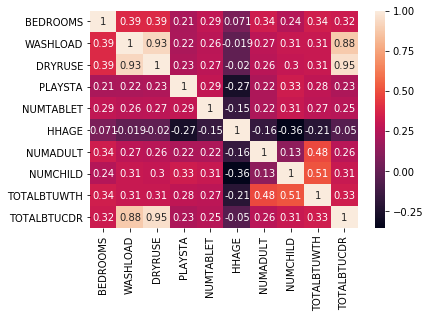




Selected Features for NUMADULT
Index(['BEDROOMS', 'OUTGRILL', 'WASHLOAD', 'DRYRUSE', 'TVCOLOR', 'NUMLAPTOP',
       'NHSLDMEM', 'MONEYPY', 'TOTALBTUWTH', 'TOTALBTUCDR'],
      dtype='object')


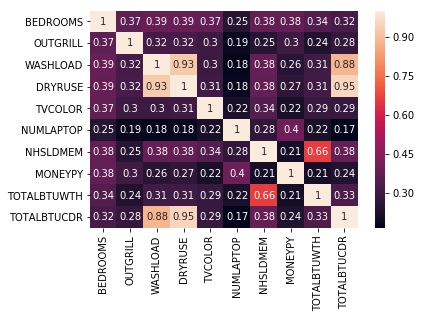




Selected Features for NUMCHILD
Index(['WASHLOAD', 'DRYRUSE', 'PLAYSTA', 'NUMTABLET', 'HHAGE', 'NHSLDMEM',
       'CUFEETNGWTH', 'BTUNGWTH', 'TOTALBTUWTH', 'TOTALBTUCDR'],
      dtype='object')


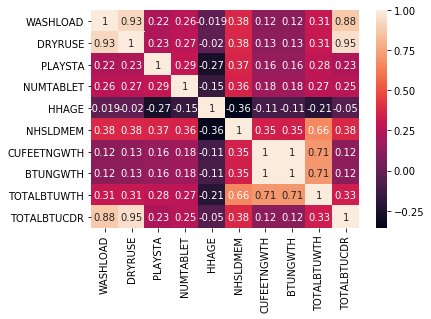




Selected Features for ATHOME
Index(['AMTMICRO', 'NUMMEAL', 'TVONWD1', 'TVONWE1', 'HHAGE', 'EMPLOYHH',
       'KWHMICRO', 'KWHTV1', 'BTUELMICRO', 'BTUELTV1'],
      dtype='object')


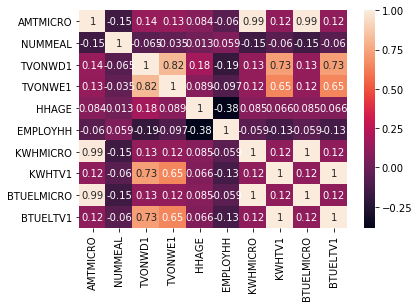




Selected Features for MONEYPY
Index(['NCOMBATH', 'TOTROOMS', 'DISHWASH', 'DWASHUSE', 'INWIRELESS',
       'LGTINNUM', 'EDUCATION', 'TOTCSQFT', 'TOTHSQFT', 'TOTSQFT_EN'],
      dtype='object')


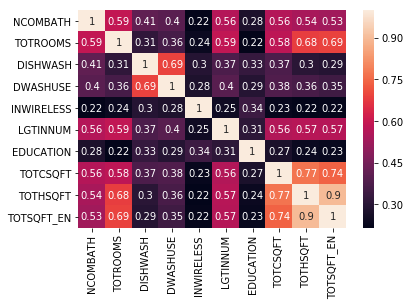

In [18]:
for target in target_list:
    show_correlation(target)
    print("\n\n")

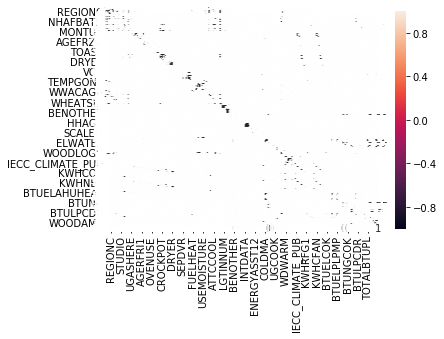

In [15]:
# correlation matrix
#Using Pearson Correlation
# plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True)
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

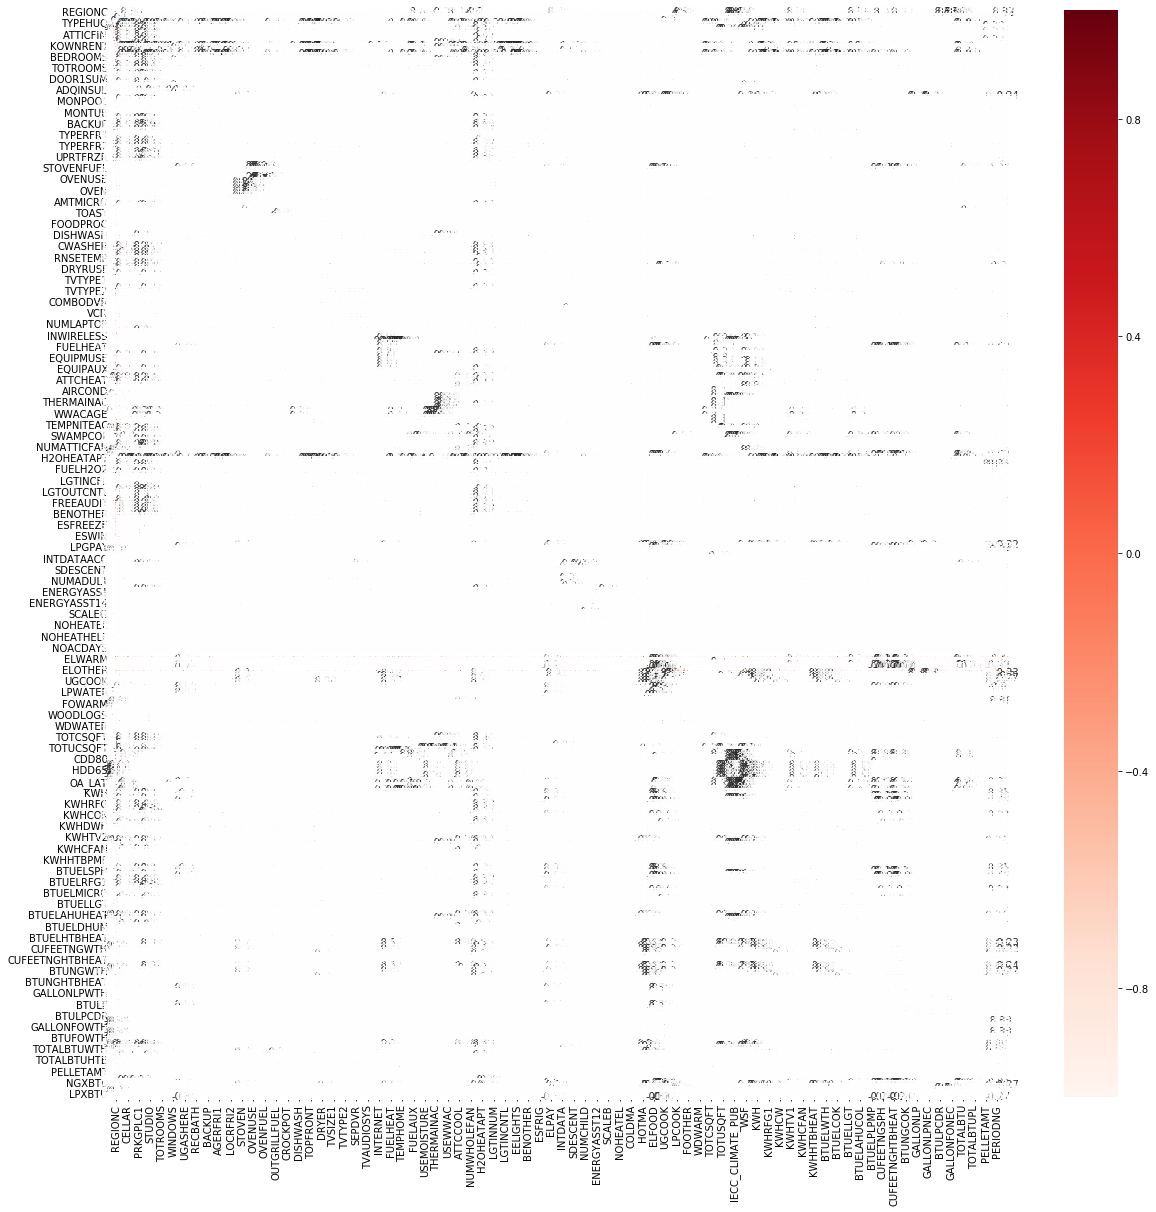

In [17]:
# plt.figure(figsize=(20,20))
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [18]:
# corr_pairs = cor.unstack()
# sorted_pairs = corr_pairs.sort_values(kind="quicksort")
# strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.8]

In [19]:
# print(strong_pairs)

USENG               NGXBTU               -1.000000
NGXBTU              USENG                -1.000000
HEATHOME            DNTHEAT              -0.990174
DNTHEAT             HEATHOME             -0.990174
SOLAR               H2OHEATAPT           -0.977274
H2OHEATAPT          SOLAR                -0.977274
STUDIO              SOLAR                -0.977165
SOLAR               STUDIO               -0.977165
GWT                 GNDHDD65             -0.975486
GNDHDD65            GWT                  -0.975486
TEMPHOME            DNTHEAT              -0.958109
DNTHEAT             TEMPHOME             -0.958109
NGXBTU              NGPAY                -0.954275
NGPAY               NGXBTU               -0.954275
GWT                 HDD30YR              -0.952472
HDD30YR             GWT                  -0.952472
IECC_CLIMATE_PUB    GWT                  -0.948356
GWT                 IECC_CLIMATE_PUB     -0.948356
HDD65               DBT99                -0.945757
DBT99               HDD65      

In [19]:
# select models for training
models = []
# # models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr'))) # usually used for binary classification
# # models.append(('NB', GaussianNB())) # performed worst for all targets

models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('ADB', AdaBoostClassifier()))
models.append(('RFC', RandomForestClassifier(n_estimators = 100, random_state = 0)))

# # ensemble methods
# cart = DecisionTreeClassifier()
# ada_cart = AdaBoostClassifier(base_estimator=cart)
# models.append(('ADB_C', ada_cart))

# level0 = list()
# level0.append(('cart', DecisionTreeClassifier()))
# rfc = RandomForestClassifier(n_estimators = 100, random_state = 0)
# rfc_cart = StackingClassifier(estimators=level0, final_estimator=rfc)
# models.append(('RFC_C', rfc_cart))

# level0 = list()
# level0.append(('cart', DecisionTreeClassifier()))
# adb = AdaBoostClassifier()
# adb_stk = StackingClassifier(estimators=level0, final_estimator=adb)
# models.append(('ADB_stk', rfc_cart))

In [20]:
# function for training
def train_model(target_col, models):
    print("---TRAINING FOR " + target_col + " ---")

    X = df.drop(target_col, axis='columns')   #Feature Matrix
    y = df[target_col]          #Target Variable

    # create traing and test sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

    # select feature subset
#     feature_selector = SelectKBest(score_func=f_classif, k=20) # select 20 features
#     X_train_selected = feature_selector.fit_transform(X_train, Y_train)
#     fit = feature_selector.fit(X_train, Y_train) # extra
    
    # show selected features
#     mask = feature_selector.get_support()
#     column_names = X_train.columns[mask]
#     print("Selected Features for " + target_col)
#     print(column_names)
    
    # Get the indices sorted by most important to least important
#     indices = np.argsort(fit.scores_)[::-1]

    # To get your top 10 feature names
#     feature_count = 10
#     features = []
#     for i in range(feature_count):
#         features.append(df.columns[indices[i]])

    # plot feature importance
#     plt.figure()
#     plt.bar(features, fit.scores_[indices[range(feature_count)]], color='g', align='center')
#     plt.xticks(rotation=45)
#     plt.title("Feature Subset for " + target_col)
#     plt.show()
    
    # evaluate each model in turn
    results = []
    names = []
    mae_arr = []
    rmse_arr = []
    r2_arr = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#         cv_results = cross_val_score(model, X_train_selected, Y_train, cv=kfold, scoring='accuracy')
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        
        # validation
        model.fit(X_train, Y_train)
        predictions = model.predict(X_validation)
        
        print(accuracy_score(Y_validation, predictions))
        print(confusion_matrix(Y_validation, predictions))
        print(classification_report(Y_validation, predictions))
        mae_value = mae(predictions, Y_validation)
        rmse_value = sqrt(mean_squared_error(Y_validation, predictions))
        r2_value = r2_score(Y_validation, predictions)
        print('Test Mean Absolute Error    ', mae_value)
        print('RMSE     ', rmse_value)
        print('Test R2    ', r2_value)
        
        mae_arr.append(mae_value)
        rmse_arr.append(rmse_value)
        r2_arr.append(r2_value)
               
        print('\n\n')
        
#         break # break after first model # for testing 1 model
        

    # Compare Algorithms
    pyplot.boxplot(results, labels=names)
    plot_title = "Traning Accuracy for " + target_col
#     pyplot.title(plot_title)
    pyplot.show()
    
    pyplot.plot(names, mae_arr, )
#     plot_title = "Test Mean Absolute Error for " + target_col
#     pyplot.title(plot_title)
#     pyplot.show()
    
    pyplot.plot(names, rmse_arr)
#     plot_title = "Test Root Mean Squared Error for " + target_col
#     pyplot.title(plot_title)
#     pyplot.show()
    
    pyplot.plot(names, r2_arr)
    plot_title = "Model Evaluation Scores for " + target_col
    pyplot.title(plot_title)
    pyplot.legend(['MAE', 'RMSE', 'R2'])
    pyplot.show()

---TRAINING FOR EQUIPMUSE ---
LDA: 0.573664 (0.016451)
0.5887521968365553
[[ 55   0   0   0   0   0   0]
 [  0 383   6  20   7  12   0]
 [  0 189  43  50   8   7   0]
 [  0  34   7 135   0   0   0]
 [  0  42  21  36  37  20   0]
 [  0   1   0   0   4  17   0]
 [  0   0   0   0   2   2   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
           1       0.59      0.89      0.71       428
           2       0.56      0.14      0.23       297
           3       0.56      0.77      0.65       176
           4       0.64      0.24      0.35       156
           5       0.29      0.77      0.42        22
           9       0.00      0.00      0.00         4

    accuracy                           0.59      1138
   macro avg       0.52      0.55      0.48      1138
weighted avg       0.60      0.59      0.53      1138

Test Mean Absolute Error     0.6291739894551845
RMSE      1.1241087076627572
Test R2     0.42437915945577076




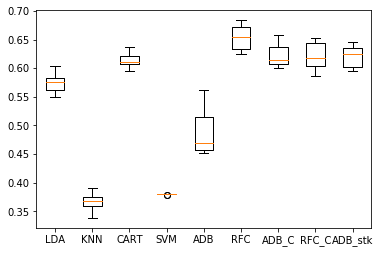

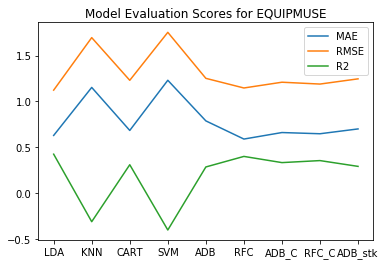




---TRAINING FOR TEMPHOME ---
LDA: 0.207788 (0.011801)
0.2100175746924429
[[55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  2  0  0  1  0  1  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  1  5  2  1  2  3  1  3  1  0  2  0  0  0  0  0  0  0  2  0  1
   0  0  0  0  0  0]
 [ 0  0  0  0  3  0  1  1  2  1  0  2  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  0  4  6  1  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  2  1  1  4  3  2  6 25  5  5  4  0  0  0  1  1  0  3  0  1
   0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  1  0  1 11  2  0  0  0  0  0  0  0  0  0  

CART: 0.422601 (0.013252)
0.4226713532513181
[[ 55   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   2   0   1   0   0   1   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1   0   2   7   0   1   4   0   4   0   0   0   0   3
    0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0   5   0   0   1   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   3   1   2   1   5   1   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   4   1   1   2  24   3   1  12   1   7   1   3   0   0   3
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0  

ADB: 0.259894 (0.001552)
0.2618629173989455
[[ 55   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  24   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  15   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  64   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   

ADB_C: 0.420397 (0.015780)
0.4147627416520211
[[ 55   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   1   0   0   0   1   1   1   1   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   2   5   0   1   5   1   5   0   0   0   0
    2   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   4   0   1   1   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   2   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   3   2   2   0   5   0   1   1   0   0   0
    0   0   0   0   0   0   0   0

ADB_stk: 0.421065 (0.015336)
0.4305799648506151
[[ 55   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   1   0   0   1   0   1   0   2   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   4   0   1   5   0   8   0   1   0   0   3
    0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   5   0   0   6   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   1   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   3   0   0   5   0   4   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  24   0   0  15   1  17   1   2   0   1   3
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

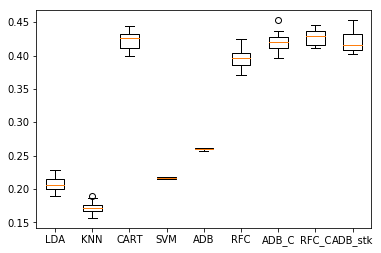

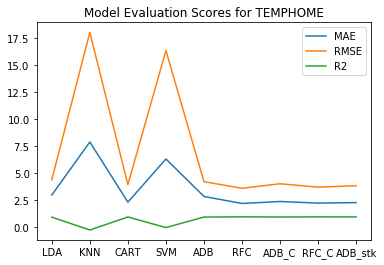




---TRAINING FOR TEMPGONE ---
LDA: 0.187338 (0.016879)
0.19068541300527242
[[55  0  0 ...  0  0  0]
 [ 0  7  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.17      0.27      0.21        26
          53       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         2
          55       0.08      0.21      0.12        14
          56       0.00      0.00      0.00         4
          57       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         9
          59       0.00      0.00      0.00         3
          60       0.18      0.09      0.12        82
          61       0.00      0.00      0.00         4
          62       0.16      0.14      0.15        36
          63       0.04      0.06      0.05        16
          

ADB: 0.199428 (0.001646)
0.19156414762741653
[[55  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.00      0.00      0.00        26
          53       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         2
          55       0.00      0.00      0.00        14
          56       0.00      0.00      0.00         4
          57       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         9
          59       0.00      0.00      0.00         3
          60       0.00      0.00      0.00        82
          61       0.00      0.00      0.00         4
          62       0.00      0.00      0.00        36
          63       0.00      0.00      0.00        16
          64       0.00      0.00      0.0

ADB_stk: 0.361697 (0.017550)
0.36291739894551844
[[55  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.00      0.00      0.00        26
          53       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         2
          55       0.00      0.00      0.00        14
          56       0.00      0.00      0.00         4
          57       0.00      0.00      0.00         2
          58       0.25      0.33      0.29         9
          59       0.00      0.00      0.00         3
          60       0.22      0.29      0.25        82
          61       0.00      0.00      0.00         4
          62       0.24      0.22      0.23        36
          63       0.22      0.38      0.28        16
          64       0.24      0.29     

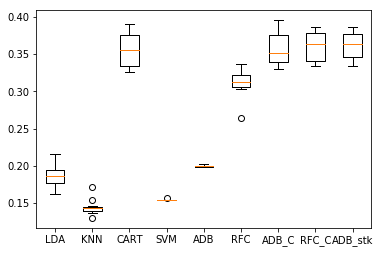

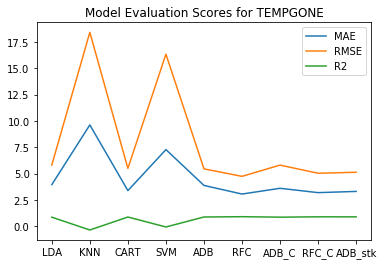




---TRAINING FOR TEMPNITE ---
LDA: 0.189088 (0.015626)
0.19507908611599298
[[55  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.00      0.00      0.00        10
          52       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          55       0.20      0.19      0.19        16
          56       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         7
          59       0.00      0.00      0.00         4
          60       0.16      0.29      0.20        58
          61       0.00      0.00      0.00         3
          62       0.11      0.20      0.14        30
          63       0.07      0.10      0.08        21
          

ADB: 0.231969 (0.018016)
0.2398945518453427
[[55  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.00      0.00      0.00        10
          52       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          55       0.00      0.00      0.00        16
          56       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         7
          59       0.00      0.00      0.00         4
          60       0.00      0.00      0.00        58
          61       0.00      0.00      0.00         3
          62       0.00      0.00      0.00        30
          63       0.00      0.00      0.00        21
          64       0.00      0.00      0.00

ADB_stk: 0.360814 (0.018362)
0.36818980667838314
[[55  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        55
          50       0.00      0.00      0.00        10
          52       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          55       0.00      0.00      0.00        16
          56       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         2
          58       0.25      0.29      0.27         7
          59       0.00      0.00      0.00         4
          60       0.15      0.16      0.15        58
          61       0.00      0.00      0.00         3
          62       0.20      0.27      0.23        30
          63       0.30      0.14      0.19        21
          64       0.00      0.00     

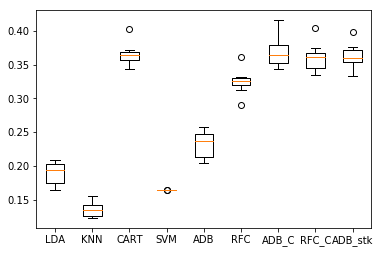

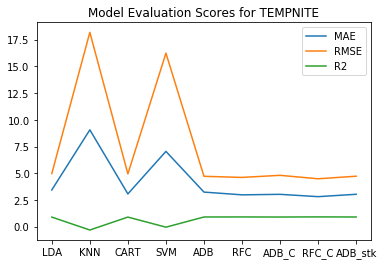




---TRAINING FOR USEWWAC ---
LDA: 0.826515 (0.009692)
0.8497363796133568
[[888   0   0   0   0   0   0]
 [  0  25  39   4   8   0   0]
 [  0  11  30   4   6   0   0]
 [  0   3   4   2   3   0   0]
 [  0  19  63   5  21   0   0]
 [  0   0   0   0   0   1   0]
 [  0   0   1   0   1   0   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       888
           1       0.43      0.33      0.37        76
           2       0.22      0.59      0.32        51
           3       0.13      0.17      0.15        12
           4       0.54      0.19      0.29       108
           5       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.85      1138
   macro avg       0.47      0.47      0.45      1138
weighted avg       0.87      0.85      0.85      1138

Test Mean Absolute Error     0.273286467486819
RMSE      0.7769753441474223
Test R2     0.856220670336095



K

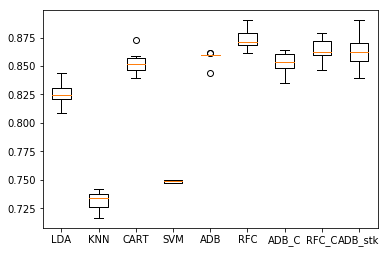

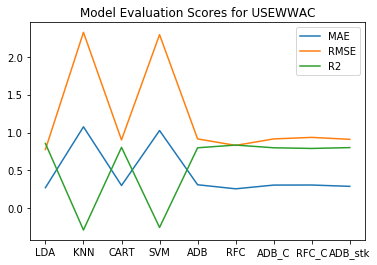




---TRAINING FOR TEMPHOMEAC ---
LDA: 0.327614 (0.011898)
0.29964850615114236
[[147   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       147
          50       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         0
          59       0.00      0.00      0.00         2
          60       0.28      0.42      0.33        24
          61       0.00      0.00      0.00         1
          62       0.20      0.17      0.18         6
          63       0.00      0.00      0.00         3
          64       0.00      0.00      0.00         4
          65       0.27      0.20      0.23        30
          66       0.00      0.00      0.00         7
          67       0.00      0.00      0.00         8
          68       0.25   

ADB: 0.268470 (0.001827)
0.2741652021089631
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  24   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   6   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0

ADB_C: 0.518470 (0.021685)
0.523725834797891
[[147   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       147
          50       0.00      0.00      0.00         1
          55       0.00      0.00      0.00         0
          59       0.00      0.00      0.00         2
          60       0.36      0.33      0.35        24
          61       0.00      0.00      0.00         1
          62       0.50      0.33      0.40         6
          63       0.00      0.00      0.00         3
          64       0.20      0.25      0.22         4
          65       0.42      0.37      0.39        30
          66       0.14      0.14      0.14         7
          67       0.43      0.38      0.40         8
          68       0.39      0.40      0.40        67
      

ADB_stk: 0.525289 (0.020800)
0.538664323374341
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  10   0   0   0   0   1   0   0   3   2   4   0   2   0   0
    2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   2   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0 

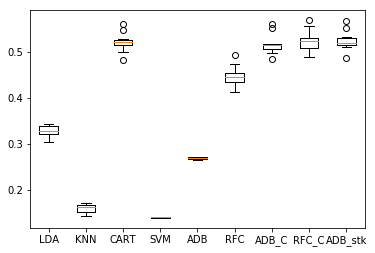

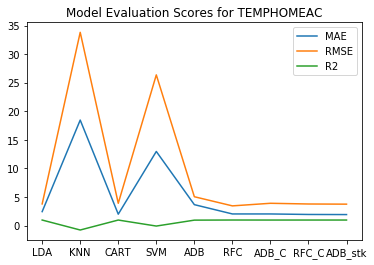




---TRAINING FOR TEMPGONEAC ---
LDA: 0.288261 (0.014443)
0.27680140597539543
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   1   1   0   0   4   0   1   2   0   6   0   0   0   1   0   0
    0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   1   0   1   6   0  10   0   1   0   1   2   0
    0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 

CART: 0.431395 (0.017710)
0.4235500878734622
[[147   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   2]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       147
          50       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         0
          60       0.33      0.28      0.30        18
          62       0.20      0.25      0.22         4
          64       0.00      0.00      0.00         1
          65       0.17      0.16      0.16        25
          66       0.00      0.00      0.00         3
          67       0.33      0.12      0.18         8
          68       0.53      0.45      0.49        53
          69       0.45      0.62      0.53         8
          70       0.51      0.52      0.52       109
          71       0.89      0.47      0.62        17
      

RFC: 0.382139 (0.016427)
0.36994727592267135
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0  13   0   2   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   2   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  15   0   2   0   0   6   0   0
    0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   1   0   0   1   0   0
    0 

ADB_stk: 0.432707 (0.017468)
0.4270650263620387
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   7   0   0   1   0   1   0   0   0   0   1   0   0
    0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   2   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   1   0   5   0   0   1   1   3   0   4   0   0   4   0   0
    0   0   4   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   5   0   0   0   0   1   0   0
   

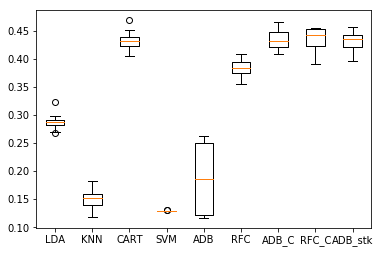

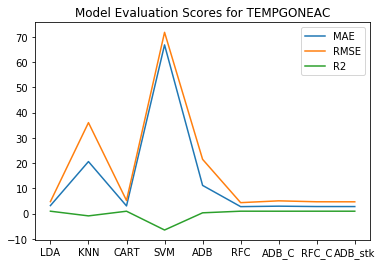




---TRAINING FOR TEMPNITEAC ---
LDA: 0.264514 (0.016389)
0.27680140597539543
[[147   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       147
          50       0.00      0.00      0.00         2
          54       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         1
          58       0.00      0.00      0.00         0
          60       0.26      0.36      0.30        28
          61       0.00      0.00      0.00         1
          62       0.00      0.00      0.00         6
          63       0.00      0.00      0.00         3
          64       0.00      0.00      0.00         5
          65       0.10      0.24      0.14        37
          66       0.07   

ADB: 0.289358 (0.002586)
0.28910369068541303
[[144   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  28   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   

ADB_C: 0.469658 (0.011866)
0.45957820738137084
[[147   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       147
          50       0.00      0.00      0.00         2
          55       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         1
          58       0.00      0.00      0.00         0
          60       0.30      0.29      0.29        28
          61       0.00      0.00      0.00         1
          62       0.33      0.33      0.33         6
          63       0.00      0.00      0.00         3
          64       0.17      0.20      0.18         5
          65       0.30      0.43      0.36        37
          66       0.11      0.11      0.11         9
          67       0.33      0.23      0.27        13
    

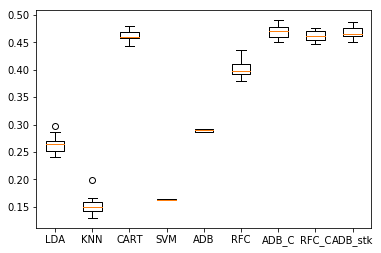

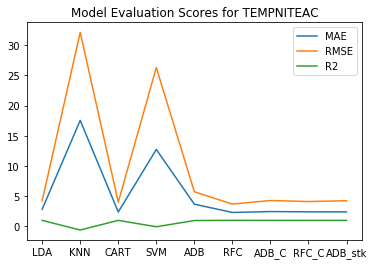




---TRAINING FOR HHAGE ---
LDA: 0.579374 (0.019052)
0.6115992970123023
[[  6 122  11   1]
 [  0 293  63   1]
 [  2 105 308  46]
 [  0  10  81  89]]
              precision    recall  f1-score   support

           2       0.75      0.04      0.08       140
           3       0.55      0.82      0.66       357
           4       0.67      0.67      0.67       461
           5       0.65      0.49      0.56       180

    accuracy                           0.61      1138
   macro avg       0.65      0.51      0.49      1138
weighted avg       0.64      0.61      0.58      1138

Test Mean Absolute Error     0.4112478031634446
RMSE      0.6772735582903165
Test R2     0.42855713649442007



KNN: 0.406778 (0.021345)
0.4244288224956063
[[ 43  59  33   5]
 [ 42 184 113  18]
 [ 36 160 236  29]
 [ 14  58  88  20]]
              precision    recall  f1-score   support

           2       0.32      0.31      0.31       140
           3       0.40      0.52      0.45       357
           4       

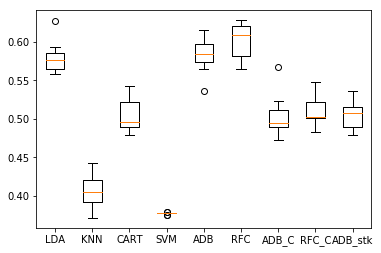

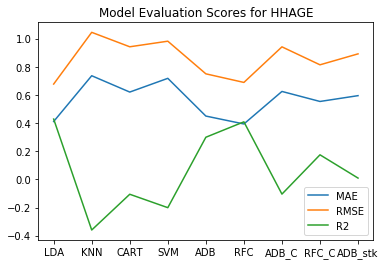




---TRAINING FOR EMPLOYHH ---
LDA: 0.684691 (0.021623)
0.679261862917399
[[396  77   0]
 [157 377   0]
 [ 80  51   0]]
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       473
           1       0.75      0.71      0.73       534
           2       0.00      0.00      0.00       131

    accuracy                           0.68      1138
   macro avg       0.46      0.51      0.48      1138
weighted avg       0.61      0.68      0.64      1138

Test Mean Absolute Error     0.39103690685413006
RMSE      0.7291326672130306
Test R2     -0.20705554815318705



KNN: 0.469878 (0.022076)
0.4903339191564148
[[254 218   1]
 [224 303   7]
 [ 56  74   1]]
              precision    recall  f1-score   support

           0       0.48      0.54      0.50       473
           1       0.51      0.57      0.54       534
           2       0.11      0.01      0.01       131

    accuracy                           0.49      1138
   macro avg       0.3

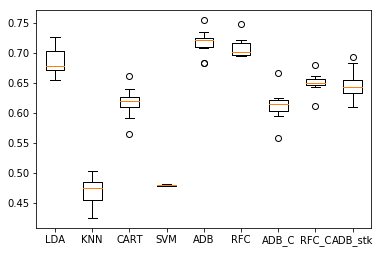

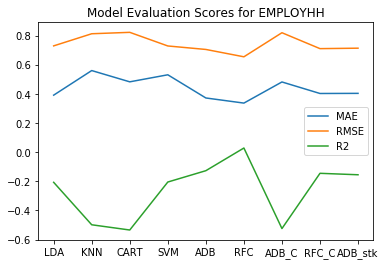




---TRAINING FOR EDUCATION ---
LDA: 0.403253 (0.014837)
0.37258347978910367
[[ 26  19  36   3   0]
 [ 17  21 217  15   1]
 [  6  22 286  51   8]
 [  2   4 140  75  19]
 [  2   0  85  67  16]]
              precision    recall  f1-score   support

           1       0.49      0.31      0.38        84
           2       0.32      0.08      0.12       271
           3       0.37      0.77      0.50       373
           4       0.36      0.31      0.33       240
           5       0.36      0.09      0.15       170

    accuracy                           0.37      1138
   macro avg       0.38      0.31      0.30      1138
weighted avg       0.36      0.37      0.32      1138

Test Mean Absolute Error     0.7785588752196837
RMSE      1.049730068240744
Test R2     0.16927778699475216



KNN: 0.288920 (0.017116)
0.2565905096660808
[[  4  31  32  13   4]
 [ 17  79 122  43  10]
 [ 21 118 146  61  27]
 [  6  57 113  43  21]
 [  3  48  69  30  20]]
              precision    recall  f1-score   

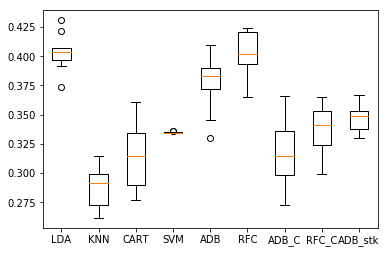

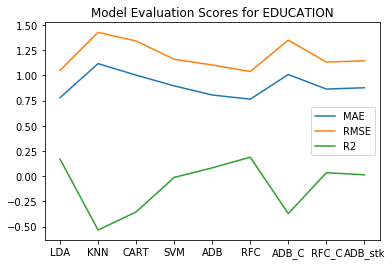




---TRAINING FOR NHSLDMEM ---
LDA: 0.955604 (0.133187)
0.9991212653778558
[[259   0   0   0   0   0   0   0   0   0   0   0]
 [  0 433   0   0   0   0   0   0   0   0   0   0]
 [  0   0 181   0   0   0   0   0   0   0   0   0]
 [  0   0   0 137   0   0   0   0   0   0   0   0]
 [  0   0   0   0  76   0   0   0   0   0   0   0]
 [  0   0   0   0   0  35   0   0   0   0   0   0]
 [  0   0   0   0   0   0   8   0   0   0   0   0]
 [  0   0   0   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       433
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       137
           5       1.00      1.00      1

ADB_C: 0.993625 (0.003735)
0.9894551845342706
[[259   0   0   0   0   0   0   0   0   0   0]
 [  0 433   0   0   0   0   0   0   0   0   0]
 [  0   0 181   0   0   0   0   0   0   0   0]
 [  0   0   0 137   0   0   0   0   0   0   0]
 [  0   0   0   0  76   0   0   0   0   0   0]
 [  0   0   0   0   0  32   3   0   0   0   0]
 [  0   0   0   0   0   0   6   2   0   0   0]
 [  0   0   0   0   0   1   2   2   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       433
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       137
           5       1.00      1.00      1.00        76
           6       0.97      0.91      0.94        35
           7       0.50      0.75      0.60         8
   

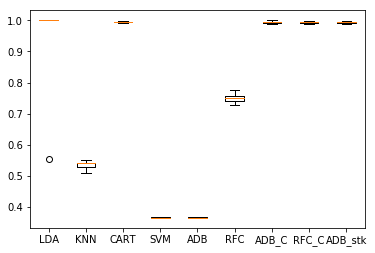

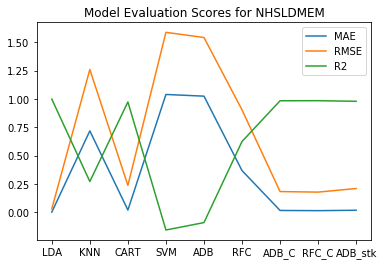




---TRAINING FOR NUMADULT ---
LDA: 0.962556 (0.110870)
1.0
[[316   0   0   0   0   0   0   0]
 [  0 611   0   0   0   0   0   0]
 [  0   0 135   0   0   0   0   0]
 [  0   0   0  57   0   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   1]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       611
           3       1.00      1.00      1.00       135
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1

    accuracy                           1.00      1138
   macro avg       1.00      1.00      1.00      1138
weighted avg       1.00      1.00      1.00      1138

Test Me

ADB_stk: 0.992743 (0.003686)
0.9885764499121266
[[315   1   0   0   0   0   0   0]
 [  0 611   0   0   0   0   0   0]
 [  1   1 133   0   0   0   0   0]
 [  0   0   0  57   0   0   0   0]
 [  0   1   0   3   5   2   0   0]
 [  0   0   0   2   0   4   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       611
           3       1.00      0.99      0.99       135
           4       0.92      1.00      0.96        57
           5       1.00      0.45      0.62        11
           6       0.50      0.67      0.57         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.99      1138
   macro avg       0.68      0.64      0.64      1138
weighted avg       0.99      0.99      0.99      1138

Test Mean Absolute E

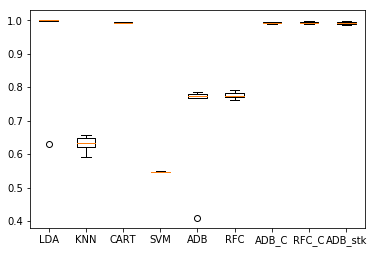

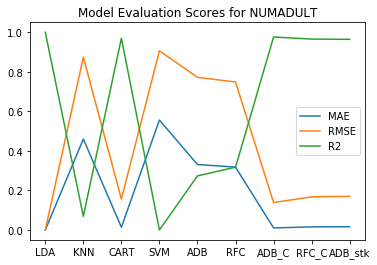




---TRAINING FOR NUMCHILD ---
LDA: 0.969890 (0.089599)
0.9982425307557118
[[780   0   0   0   0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0]
 [  0   0   0  51   0   0   0   0   0   0]
 [  0   0   0   0  17   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       780
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       124
           3       1.00      1.00      1.00        51
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00         4
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
      

RFC_C: 0.990765 (0.003651)
0.9894551845342706
[[779   0   1   0   0   0   0   0]
 [  1 158   1   0   0   0   0   0]
 [  1   1 122   0   0   0   0   0]
 [  0   1   1  49   0   0   0   0]
 [  0   0   1   0  16   0   0   0]
 [  0   0   1   0   1   2   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   0   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       780
           1       0.99      0.99      0.99       160
           2       0.96      0.98      0.97       124
           3       1.00      0.96      0.98        51
           4       0.89      0.94      0.91        17
           5       0.67      0.50      0.57         4
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.99      1138
   macro avg       0.69      0.67      0.68      1138
weighted avg       0.99      0.99      0.99      1138

Test Mean Absolute Err

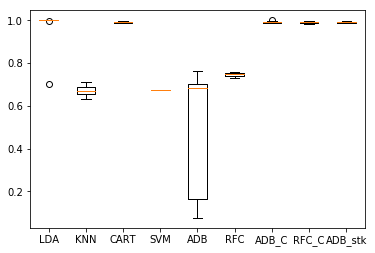

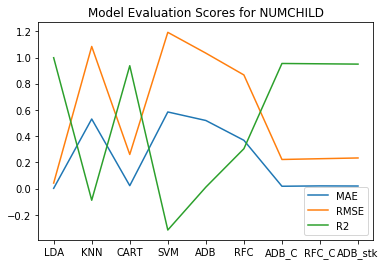




---TRAINING FOR ATHOME ---
LDA: 0.519352 (0.015304)
0.5061511423550088
[[ 99   1   1   1   6  64]
 [ 45   4   0   1   1  38]
 [ 65   0   0   7   7  39]
 [ 25   0   0   1   2  32]
 [ 13   1   0   0   4  36]
 [137   3   2  11  24 468]]
              precision    recall  f1-score   support

           0       0.26      0.58      0.36       172
           1       0.44      0.04      0.08        89
           2       0.00      0.00      0.00       118
           3       0.05      0.02      0.02        60
           4       0.09      0.07      0.08        54
           5       0.69      0.73      0.71       645

    accuracy                           0.51      1138
   macro avg       0.26      0.24      0.21      1138
weighted avg       0.47      0.51      0.47      1138

Test Mean Absolute Error     1.5826010544815465
RMSE      2.5134086811726473
Test R2     -0.6311585037116907



KNN: 0.429635 (0.013769)
0.45606326889279436
[[ 39   6   7   2   2 116]
 [ 22   0   6   2   2  57]
 [ 23   4

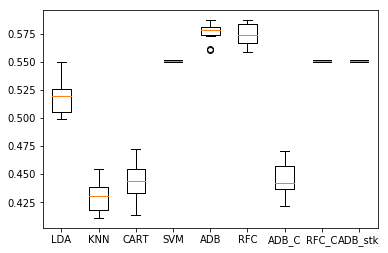

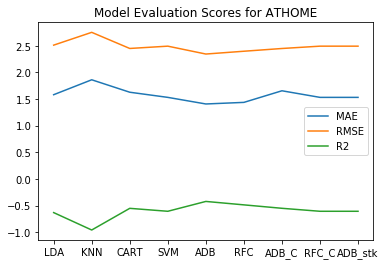




---TRAINING FOR MONEYPY ---
LDA: 0.292435 (0.020816)
0.3145869947275923
[[126  12  43   5   2   2   3   0]
 [ 81  34 103  16   8   9   2   2]
 [ 25  22  92  12  14   7  10   3]
 [ 11   7  44  17  22  25  12   8]
 [  2   3  32   8  23   7  18   8]
 [  3   6  17   7  13  18   8  10]
 [  2   0  11   2  12  11  10   6]
 [  3   0  13   4  14  18  32  38]]
              precision    recall  f1-score   support

           1       0.50      0.65      0.57       193
           2       0.40      0.13      0.20       255
           3       0.26      0.50      0.34       185
           4       0.24      0.12      0.16       146
           5       0.21      0.23      0.22       101
           6       0.19      0.22      0.20        82
           7       0.11      0.19      0.13        54
           8       0.51      0.31      0.39       122

    accuracy                           0.31      1138
   macro avg       0.30      0.29      0.28      1138
weighted avg       0.34      0.31      0.30     

ADB_stk: 0.277268 (0.016980)
0.29086115992970124
[[ 90  79   6   0   0   0   0  18]
 [ 43 171  15   0   0   0   0  26]
 [ 26 121   9   0   0   0   0  29]
 [ 12  75  21   0   0   0   0  38]
 [  6  51  12   0   0   0   0  32]
 [  1  35  19   0   0   0   0  27]
 [  3  26   6   0   0   0   0  19]
 [  3  37  21   0   0   0   0  61]]
              precision    recall  f1-score   support

           1       0.49      0.47      0.48       193
           2       0.29      0.67      0.40       255
           3       0.08      0.05      0.06       185
           4       0.00      0.00      0.00       146
           5       0.00      0.00      0.00       101
           6       0.00      0.00      0.00        82
           7       0.00      0.00      0.00        54
           8       0.24      0.50      0.33       122

    accuracy                           0.29      1138
   macro avg       0.14      0.21      0.16      1138
weighted avg       0.19      0.29      0.22      1138

Test Mean Absolute 

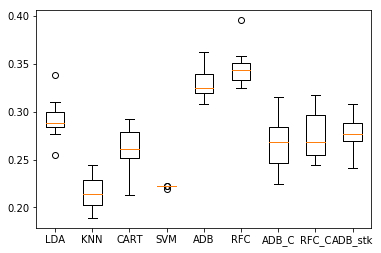

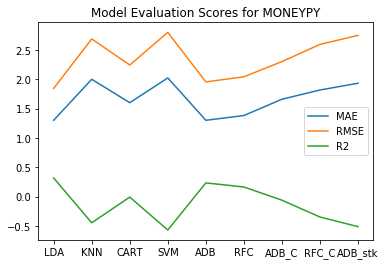

In [21]:
for target in target_list:
    train_model(target, models)
    print("\n\n")
#     break # break after first one # for testing 1 target 

In [42]:
# import sklearn
# print('sklearn: {}'.format(sklearn.__version__))

sklearn: 0.20.1


---TRAINING FOR HHAGE ---
LDA: 0.579374 (0.019052)
0.6115992970123023
[[  6 122  11   1]
 [  0 293  63   1]
 [  2 105 308  46]
 [  0  10  81  89]]
              precision    recall  f1-score   support

           2       0.75      0.04      0.08       140
           3       0.55      0.82      0.66       357
           4       0.67      0.67      0.67       461
           5       0.65      0.49      0.56       180

    accuracy                           0.61      1138
   macro avg       0.65      0.51      0.49      1138
weighted avg       0.64      0.61      0.58      1138

Test Mean Absolute Error     0.4112478031634446
RMSE      0.6772735582903165
Test R2     0.42855713649442007



KNN: 0.406778 (0.021345)
0.4244288224956063
[[ 43  59  33   5]
 [ 42 184 113  18]
 [ 36 160 236  29]
 [ 14  58  88  20]]
              precision    recall  f1-score   support

           2       0.32      0.31      0.31       140
           3       0.40      0.52      0.45       357
           4       0.5

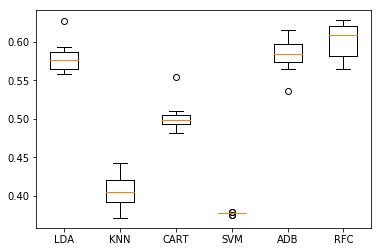

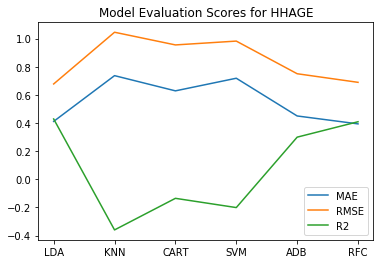

In [21]:
train_model('HHAGE', models)
print("\n\n")

In [ ]:
######### OLD CODE FROM HERE ##########################

In [7]:
# print all column name

# s = ""
# for col_name in df.columns: 
#     s += " " + col_name
# print(s)

In [9]:
# method to preview one data
def previewOneRow(df):
    for col_name in df.columns: 
        print(col_name + " "+ str(df.get(col_name)[0]))
previewOneRow(df)

DOEID 10001
REGIONC 4
DIVISION 10
METROMICRO METRO
UATYP10 U
TYPEHUQ 2
ZTYPEHUQ 0
CELLAR 0
ZCELLAR 0
BASEFIN -2
ZBASEFIN -2
ATTIC 0
ZATTIC 0
ATTICFIN -2
ZATTICFIN -2
STORIES 20
ZSTORIES 0
PRKGPLC1 1
ZPRKGPLC1 0
SIZEOFGARAGE 2
ZSIZEOFGARAGE 0
KOWNRENT 1
ZKOWNRENT 0
YEARMADERANGE 7
ZYEARMADERANGE 0
OCCUPYYRANGE 8
ZOCCUPYYRANGE 0
STUDIO -2
ZSTUDIO -2
BEDROOMS 3
ZBEDROOMS 0
NCOMBATH 2
ZNCOMBATH 0
NHAFBATH 1
ZNHAFBATH 0
OTHROOMS 4
ZOTHROOMS 0
TOTROOMS 7
ZTOTROOMS 0
WALLTYPE 4
ZWALLTYPE 0
ROOFTYPE 1
ZROOFTYPE 0
HIGHCEIL 1
ZHIGHCEIL 0
DOOR1SUM 2
ZDOOR1SUM 0
WINDOWS 41
ZWINDOWS 0
TYPEGLASS 2
ZTYPEGLASS 0
WINFRAME 2
ZWINFRAME 0
ADQINSUL 2
ZADQINSUL 0
DRAFTY 4
ZDRAFTY 0
UGASHERE 1
ZUGASHERE 0
SWIMPOOL 0
ZSWIMPOOL 0
MONPOOL -2
ZMONPOOL -2
POOL -2
ZPOOL -2
FUELPOOL -2
ZFUELPOOL -2
RECBATH 0
ZRECBATH 0
MONTUB -2
ZMONTUB -2
FUELTUB -2
ZFUELTUB -2
OUTLET 1
ZOUTLET 0
ALTFUELPEV 0
ZALTFUELPEV 0
BACKUP 1
ZBACKUP 0
SOLAR 0
NUMFRIG 1
ZNUMFRIG 0
SIZRFRI1 3
ZSIZRFRI1 0
TYPERFR1 5
ZTYPERFR1 0
AGERFRI1 3
ZAGE

In [10]:
# categorial columns
    # METROMICRO 
    # UATYP10 
    # CLIMATE_REGION_PUB
    # IECC_CLIMATE_PUB
    
# preview categorical data
print(df['METROMICRO'].unique())
print(df['UATYP10'].unique())
print(df['CLIMATE_REGION_PUB'].unique())
print(df['IECC_CLIMATE_PUB'].unique())

['METRO' 'NONE' 'MICRO']
['U' 'R' 'C']
['Hot-Dry/Mixed-Dry' 'Hot-Humid' 'Mixed-Humid' 'Cold/Very Cold' 'Marine']
['3B-4B' '1A-2A' '3A' '4A' '5A' '6A-6B' '5B-5C' '4C' '3C' '2B'
 '7A-7B-7AK-8AK']


In [11]:
# replace categorial data 
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['METROMICRO'] = LE.fit_transform(df['METROMICRO'])
df['UATYP10'] = LE.fit_transform(df['UATYP10'])
df['CLIMATE_REGION_PUB'] = LE.fit_transform(df['CLIMATE_REGION_PUB'])
df['IECC_CLIMATE_PUB'] = LE.fit_transform(df['IECC_CLIMATE_PUB'])


In [12]:
# removing INF and NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(99999, inplace=True)

In [26]:
def train_model(target_col):
    print("---TRAINING FOR " + target_col + " ---")

    X = df.drop(target_col, axis='columns')   #Feature Matrix
    y = df[target_col]          #Target Variable

    # create traing and test sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

    # select feature subset
    feature_selector = SelectKBest(score_func=f_classif, k=20) # select 20 features
    X_train_selected = feature_selector.fit_transform(X_train, Y_train)
    fit = feature_selector.fit(X_train, Y_train) # extra
    
    # show selected features
    mask = feature_selector.get_support()
    column_names = X_train.columns[mask]
    print("Selected Features for " + target_col)
    print(column_names)
    
    # Get the indices sorted by most important to least important
    indices = np.argsort(fit.scores_)[::-1]

    # To get your top 10 feature names
    feature_count = 10
    features = []
    for i in range(feature_count):
        features.append(df.columns[indices[i]])

    # plot feature importance
    plt.figure()
    plt.bar(features, fit.scores_[indices[range(feature_count)]], color='g', align='center')
    plt.xticks(rotation=45)
    plt.title("Feature Subset for " + target_col)
    plt.show()
    
    #select models for training
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('ADB', AdaBoostClassifier()))
    models.append(('RFC', RandomForestClassifier())) 
       

    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train_selected, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
    
        
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        

    # Compare Algorithms
    pyplot.boxplot(results, labels=names)
    plot_title = "Algorithm Comparison for " + target_col
    pyplot.title(plot_title)
    pyplot.show()

In [29]:
# target columns 
target_cols = ["NUMADULT", "HHAGE", "EMPLOYHH", "EDUCATION", "MONEYPY"]
# target_cols = ["MONEYPY"]

---TRAINING FOR NUMADULT ---
Selected Features for NUMADULT
Index(['BEDROOMS', 'TOTROOMS', 'OUTGRILL', 'ZOUTGRILLFUEL', 'WASHLOAD',
       'DRYRUSE', 'TVCOLOR', 'NUMLAPTOP', 'NUMSMPHONE', 'NHSLDMEM', 'MONEYPY',
       'KWH', 'KWHCW', 'BTUEL', 'BTUELCW', 'DOLLAREL', 'TOTALDOL',
       'TOTALBTUWTH', 'TOTALDOLWTH', 'TOTALBTUCDR'],
      dtype='object')


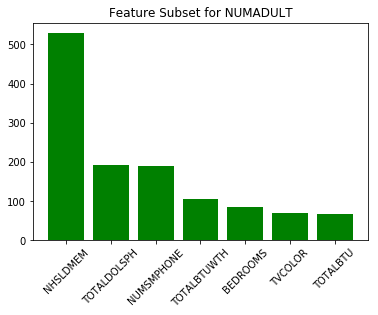

LR: 0.657726 (0.047442)
LDA: 0.699049 (0.016995)
KNN: 0.625338 (0.023188)
CART: 0.730828 (0.018447)
NB: 0.538461 (0.016430)
SVM: 0.546406 (0.002078)
ADB: 0.728031 (0.139253)
RFC: 0.769102 (0.011100)


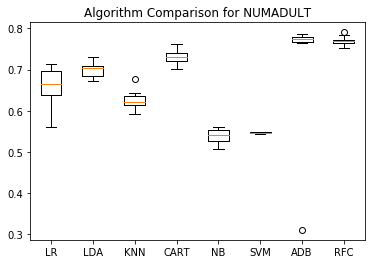




---TRAINING FOR HHAGE ---
Selected Features for HHAGE
Index(['TYPEHUQ', 'KOWNRENT', 'OCCUPYYRANGE', 'STUDIO', 'ZSTUDIO', 'SWIMPOOL',
       'ZSWIMPOOL', 'SOLAR', 'PLAYSTA', 'NUMSMPHONE', 'H2OHEATAPT',
       'ZH2OHEATAPT', 'LGTOUTNUM', 'ZLGTOUTNUM', 'EMPLOYHH', 'NHSLDMEM',
       'NUMCHILD', 'TOTALBTUWTH', 'ELXBTU', 'LPXBTU'],
      dtype='object')


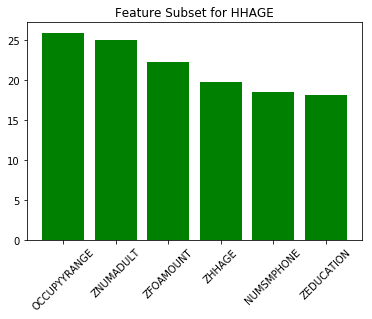

LR: 0.065494 (0.009758)
LDA: 0.041600 (0.009852)
KNN: 0.012589 (0.005350)
CART: 0.037795 (0.007364)
NB: 0.024864 (0.003677)
SVM: 0.027263 (0.005652)
ADB: 0.043804 (0.010090)
RFC: 0.040423 (0.010257)


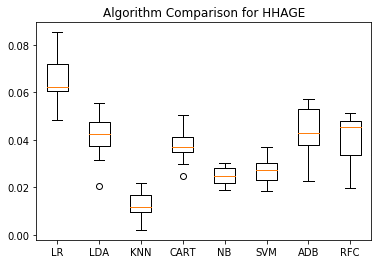




---TRAINING FOR EMPLOYHH ---
Selected Features for EMPLOYHH
Index(['OCCUPYYRANGE', 'OUTGRILL', 'TVONWD1', 'PLAYSTA', 'NUMLAPTOP',
       'NUMTABLET', 'NUMSMPHONE', 'CELLPHONE', 'INTERNET', 'INWIRELESS',
       'ZINWIRELESS', 'HHSEX', 'HHAGE', 'EDUCATION', 'NHSLDMEM', 'NUMCHILD',
       'ATHOME', 'MONEYPY', 'KWHTV1', 'BTUELTV1'],
      dtype='object')


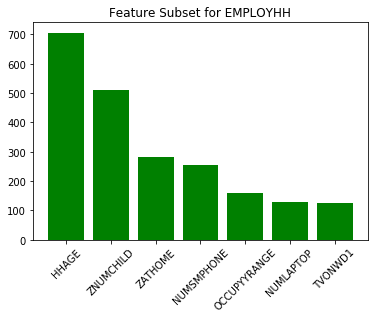

LR: 0.719897 (0.013560)
LDA: 0.721440 (0.017266)
KNN: 0.661396 (0.010224)
CART: 0.647339 (0.026196)
NB: 0.678125 (0.026118)
SVM: 0.644924 (0.015909)
ADB: 0.739471 (0.019549)
RFC: 0.721462 (0.023164)


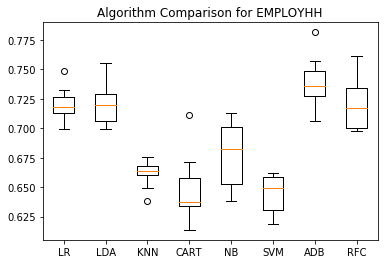




---TRAINING FOR EDUCATION ---
Selected Features for EDUCATION
Index(['NCOMBATH', 'HIGHCEIL', 'DISHWASH', 'DWASHUSE', 'ZDWASHUSE', 'DWCYCLE',
       'ZDWCYCLE', 'ZAGEDW', 'NUMLAPTOP', 'NUMTABLET', 'ELPERIPH', 'INTERNET',
       'INWIRELESS', 'ZINWIRELESS', 'LGTINNUM', 'MONEYPY', 'TOTCSQFT',
       'KWHDWH', 'BTUELDWH', 'DOLELDWH'],
      dtype='object')


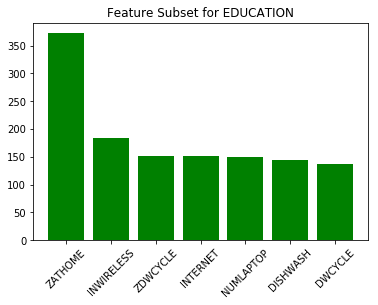

LR: 0.404347 (0.024218)
LDA: 0.396443 (0.024085)
KNN: 0.295709 (0.021133)
CART: 0.308468 (0.012615)
NB: 0.275290 (0.021410)
SVM: 0.335980 (0.013142)
ADB: 0.382166 (0.017178)
RFC: 0.342342 (0.018529)


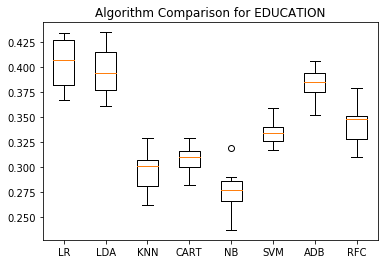




---TRAINING FOR MONEYPY ---
Selected Features for MONEYPY
Index(['STORIES', 'PRKGPLC1', 'SIZEOFGARAGE', 'BEDROOMS', 'NCOMBATH',
       'TOTROOMS', 'DISHWASH', 'DWASHUSE', 'ZDWASHUSE', 'DWCYCLE', 'ZDWCYCLE',
       'NUMLAPTOP', 'NUMTABLET', 'INWIRELESS', 'LGTINNUM', 'EDUCATION',
       'TOTCSQFT', 'TOTHSQFT', 'TOTSQFT_EN', 'DOLELDWH'],
      dtype='object')


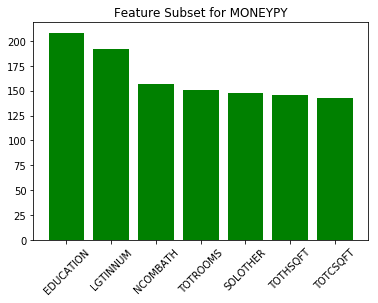

LR: 0.318394 (0.010042)
LDA: 0.321495 (0.013973)
KNN: 0.221442 (0.014590)
CART: 0.239468 (0.015626)
NB: 0.290085 (0.016660)
SVM: 0.221422 (0.006534)
ADB: 0.299048 (0.011946)
RFC: 0.278354 (0.016421)


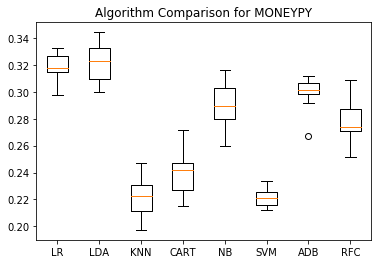

In [30]:
for target_col in target_cols:
    train_model(target_col)
    print("\n\n")

In [25]:
## NEED TO WORK ON THE FOLLOWING

In [122]:
target_col = 'NUMADULT'
X = df.drop(target_col, axis='columns')   #Feature Matrix
y = df[target_col]          #Target Variable

# create traing and test sets
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
    
# select feature subset
feature_selector = SelectKBest(score_func=f_classif, k=20) # select 20 features
X_train_selected = feature_selector.fit_transform(X_train, Y_train)

X_validation = feature_selector.transform(X_validation)


# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train_selected, Y_train)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.5369068541300527
[[  0 316   0   0   0   0   0   0]
 [  0 611   0   0   0   0   0   0]
 [  0 135   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       316
           2       0.54      1.00      0.70       611
           3       0.00      0.00      0.00       135
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

   micro avg       0.54      0.54      0.54      1138
   macro avg       0.07      0.12      0.09      1138
weighted avg       0.29      0.54      0.38      1138



In [21]:
target_col = 'NUMADULT'
X = df.drop(target_col, axis='columns')   #Feature Matrix
y = df[target_col]          #Target Variable

# create traing and test sets
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
    
# select feature subset
feature_selector = SelectKBest(score_func=f_classif, k=20) # select 20 features
X_train_selected = feature_selector.fit_transform(X_train, Y_train)

X_validation = feature_selector.transform(X_validation)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train_selected, Y_train)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.5369068541300527
[[  0 316   0   0   0   0   0   0]
 [  0 611   0   0   0   0   0   0]
 [  0 135   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       316
           2       0.54      1.00      0.70       611
           3       0.00      0.00      0.00       135
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

   micro avg       0.54      0.54      0.54      1138
   macro avg       0.07      0.12      0.09      1138
weighted avg       0.29      0.54      0.38      1138



In [23]:
# evaluate adaboost ensemble for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostRegressor

# define the model
model = AdaBoostRegressor()

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_selected, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -0.366 (0.046)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_selected, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

n_scores = cross_val_score(model, X_train_selected, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.768 (0.014)
MAE: -0.296 (0.020)


In [25]:
# evaluate adaboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
# define the model
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_selected, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.741 (0.117)


In [93]:
# # target column
# target_col = "NUMADULT"

# X = df.drop(target_col, axis='columns')   #Feature Matrix
# y = df[target_col]          #Target Variable

# # create traing and test sets
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

# # select feature subset
# feature_selector = SelectKBest(score_func=f_classif, k=20) # select 20 features
# X_train_selected = feature_selector.fit_transform(X_train, Y_train)
# fit = feature_selector.fit(X_train, Y_train) # extra

# # # summarize scores
# # set_printoptions(precision=3)
# # print(fit.scores_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  6 441 446] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  6 441 446] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [94]:
# mask = feature_selector.get_support()
# column_names = X_train.columns[mask]
# print(column_names)

Index(['BEDROOMS', 'TOTROOMS', 'OUTGRILL', 'ZOUTGRILLFUEL', 'WASHLOAD',
       'DRYRUSE', 'TVCOLOR', 'NUMLAPTOP', 'NUMSMPHONE', 'NHSLDMEM', 'MONEYPY',
       'KWH', 'KWHCW', 'BTUEL', 'BTUELCW', 'DOLLAREL', 'TOTALDOL',
       'TOTALBTUWTH', 'TOTALDOLWTH', 'TOTALBTUCDR'],
      dtype='object')


<IPython.core.display.Javascript object>


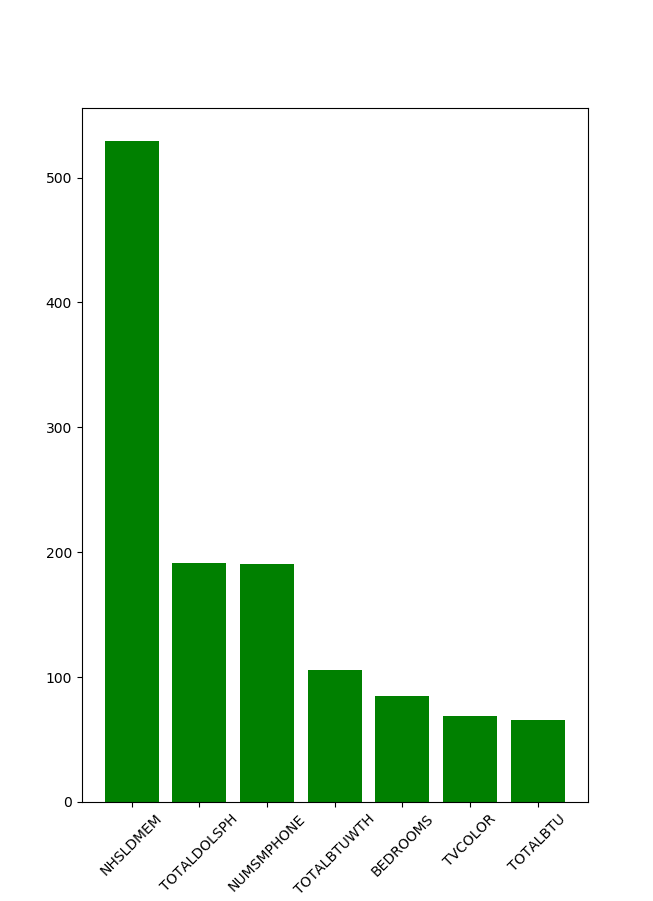

In [95]:
# # Get the indices sorted by most important to least important
# indices = np.argsort(fit.scores_)[::-1]

# # To get your top 10 feature names
# feature_count = 10
# features = []
# for i in range(feature_count):
#     features.append(df.columns[indices[i]])

# # Now plot
# plt.figure()
# plt.bar(features, fit.scores_[indices[range(feature_count)]], color='g', align='center')
# plt.xticks(rotation=45)
# plt.show()

LR: 0.657726 (0.047442)
LDA: 0.699049 (0.016995)
KNN: 0.625338 (0.023188)
CART: 0.737651 (0.016575)
NB: 0.538461 (0.016430)
SVM: 0.546406 (0.002078)


<IPython.core.display.Javascript object>


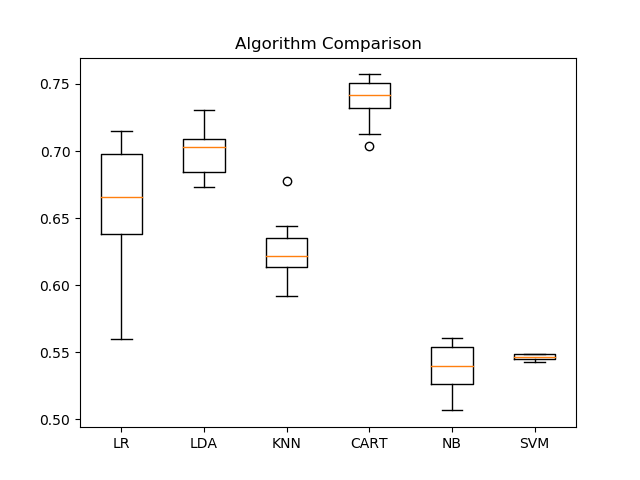

In [97]:
# models = []
# models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(gamma='auto')))

# # evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#     cv_results = cross_val_score(model, X_train_selected, Y_train, cv=kfold, scoring='accuracy')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# # Compare Algorithms
# pyplot.boxplot(results, labels=names)
# pyplot.title('Algorithm Comparison')
# pyplot.show()

LR: 0.955909 (0.044337)
LDA: 0.975641 (0.037246)
KNN: 0.950524 (0.040563)
CART: 0.958858 (0.041305)
NB: 0.951166 (0.052812)
SVM: 0.983333 (0.033333)


<IPython.core.display.Javascript object>


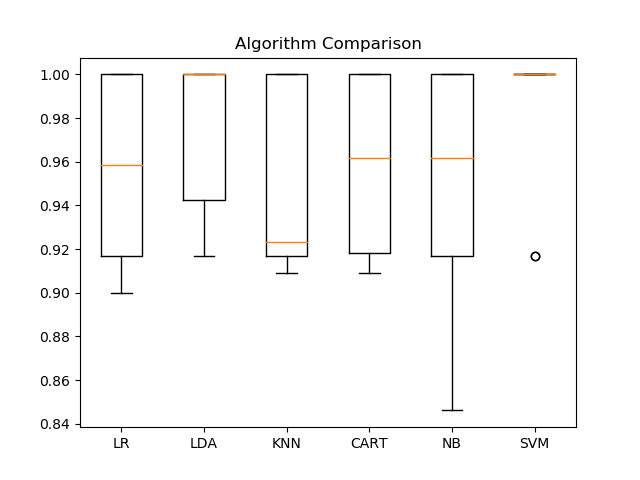

In [91]:
# ## practice resource 
# %matplotlib notebook

# # compare algorithms
# from pandas import read_csv
# from matplotlib import pyplot
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# # Load dataset
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
# names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
# dataset = read_csv(url, names=names)
# # Split-out validation dataset
# array = dataset.values
# X = array[:,0:4]
# y = array[:,4]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# # Spot Check Algorithms
# models = []
# models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(gamma='auto')))
# # evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#     cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# # Compare Algorithms
# pyplot.boxplot(results, labels=names)
# pyplot.title('Algorithm Comparison')
# pyplot.show()

In [90]:
# ## practice resource 
# %matplotlib notebook

# # make predictions
# from pandas import read_csv
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# # Load dataset
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
# names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
# dataset = read_csv(url, names=names)
# # Split-out validation dataset
# array = dataset.values
# X = array[:,0:4]
# y = array[:,4]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# # Make predictions on validation dataset
# model = SVC(gamma='auto')
# model.fit(X_train, Y_train)
# predictions = model.predict(X_validation)
# # Evaluate predictions
# print(accuracy_score(Y_validation, predictions))
# print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

      micro avg       0.97      0.97      0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



In [ ]:
# # make predictions
# from pandas import read_csv
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# # Load dataset
# # url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
# # names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
# # dataset = read_csv(url, names=names)
# # # Split-out validation dataset
# # array = dataset.values
# # X = array[:,0:4]
# # y = array[:,4]

# X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# # Make predictions on validation dataset
# model = SVC(gamma='auto')
# model.fit(X_train, Y_train)
# predictions = model.predict(X_validation)
# # Evaluate predictions
# print(accuracy_score(Y_validation, predictions))
# print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))